## Loading packages and savepaths

In [5]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import lfp_pre_processing_functions
import power_functions
import coherence_functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

In [6]:
%pip install mne-qt-browser
%matplotlib qt
import mne
print(mne.get_config())  # same as mne.get_config(key=None)
mne.set_config('MNE_BROWSER_BACKEND', 'qt')  # set the backend to matplotlib

Note: you may need to restart the kernel to use updated packages.
{'MNE_BROWSER_BACKEND': 'qt', 'MNE_BROWSE_RAW_SIZE': '20.0,12.354166666666666'}


In [7]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

if user == 'CPLab':
    base='D:\\Dropbox\\CPLab'
else:
    base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
#Set the basepath, savepath and load the data files
files = glob.glob(base+'\\all_data_mat_250825\\*.mat')
savepath = base+'\\results\\'
print("Base path:", base)
print("Save path:", savepath)
print(files)


all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}


Hello sinha
Base path: C:\Users\sinha\Dropbox\CPLab
Save path: C:\Users\sinha\Dropbox\CPLab\results\
['C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk1_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk3_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk5_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230529_dk6_nocontext.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk1_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk3_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk5_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230531_dk6_nocontext_day2.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230609_dk1_BW_nocontext_day1.mat', 'C:\\Users\\sinha\\Dropbox\\CPLab\\all_data_mat_250825\\20230609_dk3_BW_nocontext_day1.mat', 'C:\\Users\\

In [8]:
time_window = 1
fs = 2000

## Doing annotations of bad data segments

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import mne_connectivity
import sys
importlib.reload(lfp_pre_processing_functions)
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

files_short=[files[10]] ### TEST CHANGE THIS 


for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        #print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue
        # if rat_id=='dk1': #REMOVING DK1 TEMPORARLILY . PLEASE CHANGE LATER
        #     continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        #print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        ref_lfp_channels=[x for x in channels if "Ref" in x or 'REF' in x or 'ref' in x]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels, ref_lfp_channels))
        #print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        mne_epoch_around_dig=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        
        mne_baseline_data_shuffled=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs*2)))
        mne_epoch_around_dig_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs*2)))

        print(f'File {rat_id} {task} {date} has {len(epochs)} epochs and {len(all_channels)} channels')


        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli or "Ref" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                #print(raw_data.shape, raw_time.shape, sampling_rate)
                
                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)

                # padded_data = padded_data/8000 #Accounting for the 8000Amplifier
                # padd_ref_data = padd_ref_data/8000
                if "Ref" in channeli:
                    subtracted_data = padded_data
                else:                
                    subtracted_data = padded_data - padd_ref_data # Subtracting reference channel

                notch_data = lfp_pre_processing_functions.iir_notch(subtracted_data, sampling_rate, 60) ###CHANGE notch_data to notch_filtered_data

                #print(notch_data.nbytes)
                #notch_data_detrended = scipy.signal.detrend(notch_data)
                #notch_filtered_data=lfp_pre_processing_functions.sosbandpass(notch_data_detrended, fs=2000, start_freq=1,end_freq=100, order=8) ###CHANGE THIS FOR NOT BANDBASS FILTERTING
                #print(notch_filtered_data.nbytes)
                
                data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_data, raw_time, first_event, sampling_rate)
                first_event_index=np.where(raw_time>first_event)[0][0]

                mne_baseline_data[0,channel_num,:]=list(data_before)
                mne_baseline_data_shuffled[0,channel_num,:]=list(np.random.permutation(data_before))
                total = notch_data

                
                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    #print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    #print(door_timestamp, trial_type, dig_timestamp, dig_type)
                    data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_data,time,door_timestamp,sampling_rate,truncation_time=time_window)
                    data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_data,time,dig_timestamp,sampling_rate,truncation_time=time_window)
                    data_around_door=np.concatenate((data_trial_before, data_trial_after))
                    data_around_dig=np.concatenate((data_dig_before, data_dig_after))

                    epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
                    event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

                    #event_data_list = [x for x in epoch_data]

                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0][-int(time_window*fs):])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1][:int(time_window*fs)])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2][-int(time_window*fs):])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3][:int(time_window*fs)])
                    mid_point = int(len(event_data_list[4]) / 2)
                    mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])
                    mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])

                    mne_epoch_door_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[0][-int(time_window*fs):]))
                    mne_epoch_door_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[1][:int(time_window*fs)]))
                    mne_epoch_dig_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[2][-int(time_window*fs):]))
                    mne_epoch_dig_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[3][:int(time_window*fs)]))
                    mne_epoch_around_door_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]))
                    mne_epoch_around_dig_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]))

        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/3
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
            mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
            mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
            
            row_list=[file_num,date,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
            mne_baseline_shuffled = mne.EpochsArray(mne_baseline_data_shuffled, info)
            mne_epoch_door_before_shuffled = mne.EpochsArray(mne_epoch_door_before_shuffled, info)
            mne_epoch_door_after_shuffled = mne.EpochsArray(mne_epoch_door_after_shuffled, info)
            mne_epoch_dig_before_shuffled = mne.EpochsArray(mne_epoch_dig_before_shuffled, info)
            mne_epoch_dig_after_shuffled = mne.EpochsArray(mne_epoch_dig_after_shuffled, info)
            mne_epoch_around_door_shuffled = mne.EpochsArray(mne_epoch_around_door_shuffled, info)
            mne_epoch_around_dig_shuffled = mne.EpochsArray(mne_epoch_around_dig_shuffled, info)
            row_list_shuffled=[file_num,date,rat_id,task,mne_baseline_shuffled,mne_epoch_door_before_shuffled,mne_epoch_door_after_shuffled,mne_epoch_dig_before_shuffled,mne_epoch_dig_after_shuffled,mne_epoch_around_door_shuffled,mne_epoch_around_dig_shuffled]
            shuffled_event_data_df.append(row_list_shuffled)

            con_data_df.append(row_list)
            con_data_df_shuffled.append(row_list_shuffled)


con_data_df=pd.DataFrame(con_data_df, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df.to_pickle(savepath+f'raw_mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

con_data_df_shuffled=pd.DataFrame(con_data_df_shuffled, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df_shuffled.to_pickle(savepath+f'raw_mne_epochs_array_df_shuffled_truncated_{int(time_window*fs)}.pkl')


In [ ]:
con_data_df = pd.read_pickle(savepath+f'raw_mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

In [ ]:
test_epoch = con_data_df.iloc[0]['mne_epoch_dig_before']
aon_indices = [i for i, ch in enumerate(test_epoch.ch_names) if 'AON' in ch]
vHp_indices = [i for i, ch in enumerate(test_epoch.ch_names) if 'vHp' in ch]
test_epoch.plot(events=True, scalings='auto')

In [ ]:
print(con_data_df.shape[0])
for row in range(con_data_df.shape[0]):
    epoch1 = con_data_df.iloc[row]['mne_epoch_dig_before']
    epoch1.plot(events=True, scalings='auto')


In [ ]:
for row in range(con_data_df.shape[0]):
    epoch = con_data_df.iloc[row]['mne_epoch_dig_after']
    epoch.plot(events=True, scalings='auto')

In [ ]:
for row in range(con_data_df.shape[0]):
    epoch = con_data_df.iloc[row]['mne_epoch_door_before']
    epoch.plot(events=True, scalings='auto')

In [ ]:
con_data_df.to_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_181125.pkl')

In [6]:


con_data_df_marked = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_181125.pkl')

In [13]:
door_before_dropped_total = 0
dig_before_dropped_total = 0
dig_after_dropped_total = 0

for row in range(con_data_df_marked.shape[0]):
    door_before = con_data_df_marked.iloc[row]['mne_epoch_door_before']
    dig_before = con_data_df_marked.iloc[row]['mne_epoch_dig_before']    
    dig_after = con_data_df_marked.iloc[row]['mne_epoch_dig_after']
    
    door_before_epochs = len(door_before)
    dig_before_epochs = len(dig_before)
    dig_after_epochs = len(dig_after)
    
    door_before_dropped = int(20) - int(door_before_epochs)
    dig_before_dropped = int(20) - int(dig_before_epochs)
    dig_after_dropped = int(20) - int(dig_after_epochs)
    
    door_before_dropped_total = door_before_dropped_total + door_before_dropped
    dig_before_dropped_total = dig_before_dropped_total + dig_before_dropped
    dig_after_dropped_total = dig_after_dropped_total + dig_after_dropped

print("Total Door Before Epochs Dropped - ", door_before_dropped_total, "Out of", 20*27)
print("Total Dig Before Epochs Dropped - ", dig_before_dropped_total, "Out of", 20*27)
print("Total Dig After Epochs Dropped - ", dig_after_dropped_total, "Out of", 20*27)

Total Door Before Epochs Dropped -  120 Out of 540
Total Dig Before Epochs Dropped -  96 Out of 540
Total Dig After Epochs Dropped -  78 Out of 540


In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############
def coherogram_pkl(time_window, fs, tanh_norm):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'


    con_data_df_clean=con_data_df_marked

    event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)
    BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
    BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

    all_con_data=[]
    all_con_data_mean=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            task_data=task_data_dict[task_name]
            row=[task_name]
            #print(row)
            row_2=[task_name]
            for event in event_list:
                #print(event)
                event_epoch_list=task_data[event]
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch) 
                        print(event_epoch.events.shape[0])
                        if event_epoch.events.shape[0] <5:
                            
                            print(f"Skipping {event} for {task_name} due to insufficient events")
                            continue
                        fmin=1
                        fmax=100
                        fs=2000
                        freqs = np.arange(fmin,fmax)
                        n_cycles = freqs/3
                        
                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        ########TRYING HIGHPASS FILTERING FOR ARTIFACT REMOVAL################
                        # epoch_highpass = event_epoch.copy().filter(l_freq = 1, h_freq=None, filter_length = "0.7s" )
                        # con = mne_connectivity.spectral_connectivity_epochs(epoch_highpass, method='coh', sfreq=int(fs),
                        #                                     mode='cwt_morlet', cwt_freqs=freqs,
                        #                                     cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        
                        
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    coherence= coh[i,j,:,:]
                                    if tanh_norm:
                                        coherence=np.arctanh(coherence)
                                    aon_vHp_con.append(coherence)
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
    all_con_data_df.to_pickle(savepath+'marked_coherence_spectrogram_before_after_door_dig_truncated_{}{}_181125.pkl'.format(int(time_window*fs), suffix))

coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

C:\Users\sinha\AppData\Local\Temp\ipykernel_4028\2106540647.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmin = all_con_data_df[event_list].applymap(np.min).min().min()
C:\Users\sinha\AppData\Local\Temp\ipykernel_4028\2106540647.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmax = all_con_data_df[event_list].applymap(np.max).max().max()


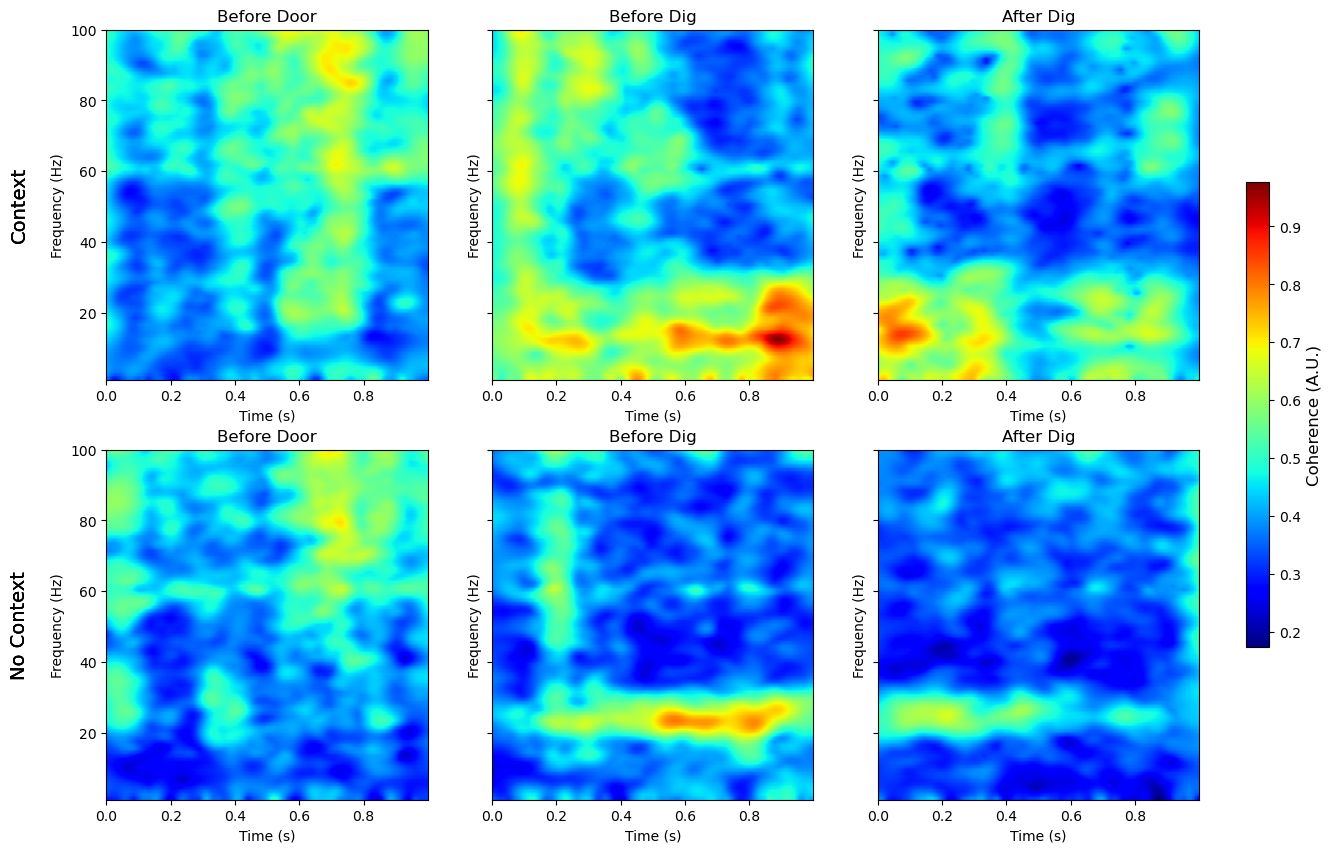

In [12]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True

###############

if tanh_norm:
    suffix ='_normalized'
else:
    suffix ='_non-normalized'

all_con_data_df=pd.read_pickle(savepath+'marked_coherence_spectrogram_before_after_door_dig_truncated_{}{}_181125.pkl'.format(int(time_window*fs), suffix))
event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

%matplotlib inline

times=np.arange(0, time_window, 1/fs)
fig, axs=plt.subplots(2,3, figsize=(15,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence (A.U.)', fontsize=12)
fig.savefig(savepath+f'marked_coherence_spectrogram_before_after_door_dig_{int(time_window*fs/2)}ms{suffix}_181125.png', dpi=1200, bbox_inches='tight')
plt.show()

## Calculating Power and Plotting

In [11]:
suffix ='_normalized'

mne_epochs = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_181125.pkl')


In [ ]:

def get_power_tfr(epoch):
    fmin=2.5
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3

    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False,
    )

    return power
results = []
for row in mne_epochs.itertuples(index=False):
    experiment, rat_id, task = row.experiment, row.rat_id, row.task
    door_before,door_after = row.mne_epoch_door_before, row.mne_epoch_door_after
    dig_before,dig_after = row.mne_epoch_dig_before, row.mne_epoch_dig_after
    around_door, around_dig = row.mne_epoch_around_door, row.mne_epoch_around_dig

    power_door_before = get_power_tfr(door_before)
    power_door_after = get_power_tfr(door_after)
    power_dig_before = get_power_tfr(dig_before)
    power_dig_after = get_power_tfr(dig_after)
    power_around_door = get_power_tfr(around_door)
    power_around_dig = get_power_tfr(around_dig)

    #net_power = power_dig_before - power_door_before
    channel_names = door_before.ch_names
    new_row = [experiment, rat_id, task,power_door_before,power_door_after,power_dig_before,power_dig_after, power_around_door, power_around_dig, channel_names]
    results.append(new_row)


ValueError: 11 columns passed, passed data had 10 columns

In [14]:

results_df = pd.DataFrame(results, columns=['experiment', 'rat_id', 'task', 'power_pre_door', 'power_post_door','power_pre_dig','power_post_dig','power_around_door','power_around_dig', 'channel_names'])
results_df.to_pickle(savepath + 'marked_power_tfr_epochs_mrlt.pkl')

In [15]:
results_df = pd.read_pickle(savepath+'marked_power_tfr_epochs_mrlt.pkl')

def make_averaged_power(epoch, area):
    #print(epoch.ch_names)
    area_channels = [channel for channel in epoch.ch_names if area in channel]
    #print(area_channels)

    if len(area_channels)==0:
        print("Error")
        return None
    else:
        area_epoch = epoch.copy()
        area_epoch.pick(area_channels)
        averaged_epoch_power = area_epoch.average(dim='epochs')
        print(f"Data shape before mean: {averaged_epoch_power.shape}")  # DEBUG
        mean_ch_power = np.mean(averaged_epoch_power.get_data(), axis = 0)
        print(f"Data shape after mean: {mean_ch_power.shape}")  # DEBUG
        return mean_ch_power

# test_averaged_epoch_power = make_averaged_power(test_power_epoch, "vHp")
# print(test_averaged_epoch_power.shape)

for area in ["AON", "vHp"]:
    area_df = pd.DataFrame()
    fig, axs = plt.subplots(2,3, figsize= (15,10))
    fig.suptitle(f'Average {area} Power')
    for rowi, task in enumerate(["BWcontext", "BWnocontext"]):
        task_data=results_df[results_df['task']==task]
        print(f"\nTask: {task}, Area: {area}, Rows in task_data: {len(task_data)}")
        for coli, event in enumerate(['power_pre_door', 'power_pre_dig','power_post_dig']):
            print(coli,event, task, area)
            event_arrays = task_data[event].apply(lambda x: make_averaged_power(x, area))
            
            valid_arrays = [arr for arr in event_arrays.values if arr is not None]
            
            print(f"Valid arrays found: {len(valid_arrays)}")
            
            if len(valid_arrays) > 0:
                averaged_array = np.mean(np.stack(valid_arrays), axis=0)
                print(f"Averaged array shape: {averaged_array.shape}")
                
                ax = axs[rowi, coli]
                im = ax.imshow(X= averaged_array, cmap = 'viridis', aspect='auto', origin='lower')
                                # Add titles and labels
                ax.set_title(f'{event.replace("_", " ").title()}')
                ax.set_xlabel('Time (samples)')
                ax.set_ylabel('Frequency (Hz)')
                ax.set_xticks(list(np.arange(0,1600,200)))
                ax.set_xticklabels(list(np.round(np.arange(0,0.8,0.1), decimals = 1)))
                # Add colorbar
                plt.colorbar(im, ax=ax, label='Power (mV^2/Hz)')
                
                # Add row labels
                if coli == 0:
                    ax.set_ylabel(f'{task}\nFrequency (Hz)', fontweight='bold')
                # Add your plotting code here
            else:
                print(f"WARNING: No valid data for {area}, {task}, {event}")
                ax = axs[rowi, coli]
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
    plt.tight_layout()
    fig.savefig(savepath+f'marked_power_spectrogram_{area}.png')
    plt.show()


Task: BWcontext, Area: AON, Rows in task_data: 15
0 power_pre_door BWcontext AON
Data shape before mean: (2, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (1, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (2, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (3, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (2, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (2, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (4, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (4, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (3, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (4, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (4, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (4, 98, 2000)
Data shape after mean: (98, 2000)
Data shape before mean: (4, 98, 2000)
Data shape after

In [ ]:

#fig = test_epoch.compute_psd(fmin=1, fmax=100, method='multitaper').plot(average=True, amplitude=False, picks="data")
test_epoch.plot_image(combine="mean", picks=aon_indices)
test_epoch.plot_image(combine="mean", picks=vHp_indices)

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib qt
import mne
import mne_connectivity
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue

        if rat_id=='dk3':
            continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)
        print(padd_ref_data, 'Reference electrode data padded to global start and end time')
        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        print(events_codes.shape, events_times.shape, 'Keyboard')
        print(events_codes)
        events_codes_all[base_name] = events_codes
        print(events_codes_all)
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        data_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels))
        #print(all_channels)
        # Convert events_codes to strings for annotation descriptions
        annotation_descriptions = [str(code) for code in events_codes]
        annotations = mne.Annotations(onset=events_times, duration=np.zeros_like(events_times), description=annotation_descriptions)
        # Remove any keys from keyboard_dict that are not present in annotation_descriptions
        
        present_keys = set(annotation_descriptions) & set(keyboard_dict.keys())
        filtered_keyboard_dict = {k: v for k, v in keyboard_dict.items() if k in present_keys}
        if len(filtered_keyboard_dict) < len(keyboard_dict):
            print(f"Filtered keyboard_dict to only present annotation descriptions: {filtered_keyboard_dict}")
        if filtered_keyboard_dict:
            annotations.rename(filtered_keyboard_dict)
        else:
            print("No matching annotation descriptions found for renaming.")
        
        all_channels = list(data_channels) + ['reference']
        info = mne.create_info(ch_names=list(all_channels), sfreq=2000, ch_types='eeg')

        all_channels_data= []

        first_event = events_times[0]
        raw_data = []
        for channel_num,channeli in enumerate(data_channels):
            if "AON" in channeli or "vHp" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()

                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,2000)

                print(len(padded_data), len(padded_data), channel_id)
                all_channels_data.append(padded_data)
            
        all_channels_data = np.array(all_channels_data)
        all_channels_data = np.vstack((all_channels_data, padd_ref_data))
        print(all_channels_data.shape)
        mne_all_channels_data = mne.io.RawArray(all_channels_data, info)
        print(mne_all_channels_data.info)
        #mne_all_channels_data.set_eeg_reference(ref_channels='average', projection=True, ch_type='eeg')
        mne_all_channels_data.set_annotations(annotations)
#mne.viz.plot_raw(mne_all_channels_data, duration=60, scalings='auto', show=True, block=True)
        all_data_epochs= mne.Epochs(mne_all_channels_data, events=None, event_id=None, tmin=-0.7, tmax=0.7, baseline=None, preload=True, verbose=True, event_repeated='drop')
        row= [file_num, rat_id, task, all_data_epochs]
        event_data_df.append(row)
event_data_df=pd.DataFrame(event_data_df, columns=['experiment','rat_id','task','epochs'])
print(event_data_df)

#                 sampling_rate = int(1 / data_all['interval'][0][0])
#                 #print(raw_data.shape, raw_time.shape, sampling_rate)
#                 subtracted_data = padded_data - padd_ref_data
#                 raw_data=subtracted_data
#                 notch_filtered_data = lfp_pre_processing_functions.iir_notch(raw_data, sampling_rate, 60)

#                 data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_filtered_data, raw_time, first_event, sampling_rate)
#                 first_event_index=np.where(raw_time>first_event)[0][0]

#                 mne_baseline_data[0,channel_num,:]=list(data_before)
#                 mne_baseline_data_shuffled[0,channel_num,:]=list(np.random.permutation(data_before))
#                 total = notch_filtered_data

                
#                 for i, epochi in enumerate(epochs):
#                     door_timestamp = epochi[0][0]
#                     trial_type = epochi[0][1]
#                     dig_type = epochi[1, 1]
#                     #print(dig_type)
#                     dig_timestamp = epochi[1, 0]
#                     #print(door_timestamp, trial_type, dig_timestamp, dig_type)
#                     data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,door_timestamp,sampling_rate,0.7)
#                     data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_filtered_data,time,dig_timestamp,sampling_rate,0.7)
#                     data_around_door=np.concatenate((data_trial_before, data_trial_after))
#                     data_around_dig=np.concatenate((data_dig_before, data_dig_after))

#                     epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
#                     event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

#                     mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0])
#                     mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1])
#                     mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2])
#                     mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3])
#                     mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4])
#                     mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5])

#                     mne_epoch_door_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[0]))
#                     mne_epoch_door_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[1]))
#                     mne_epoch_dig_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[2]))
#                     mne_epoch_dig_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[3]))
#                     mne_epoch_around_door_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[4]))
#                     mne_epoch_around_dig_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[5]))

#         if len(all_channels)>0:
#             fs=2000
#             freqs = np.arange(1,100)
#             n_cycles = freqs/3
#             info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
#             mne_baseline = mne.EpochsArray(mne_baseline_data, info)
#             mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info)
#             mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info)
#             mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info)
#             mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info)
#             mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info)
#             mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info)
            
#             row_list=[file_num,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
#             mne_baseline_shuffled = mne.EpochsArray(mne_baseline_data_shuffled, info)
#             mne_epoch_door_before_shuffled = mne.EpochsArray(mne_epoch_door_before_shuffled, info)
#             mne_epoch_door_after_shuffled = mne.EpochsArray(mne_epoch_door_after_shuffled, info)
#             mne_epoch_dig_before_shuffled = mne.EpochsArray(mne_epoch_dig_before_shuffled, info)
#             mne_epoch_dig_after_shuffled = mne.EpochsArray(mne_epoch_dig_after_shuffled, info)
#             mne_epoch_around_door_shuffled = mne.EpochsArray(mne_epoch_around_door_shuffled, info)
#             mne_epoch_around_dig_shuffled = mne.EpochsArray(mne_epoch_around_dig_shuffled, info)
#             row_list_shuffled=[file_num,rat_id,task,mne_baseline_shuffled,mne_epoch_door_before_shuffled,mne_epoch_door_after_shuffled,mne_epoch_dig_before_shuffled,mne_epoch_dig_after_shuffled,mne_epoch_around_door_shuffled,mne_epoch_around_dig_shuffled]
#             shuffled_event_data_df.append(row_list_shuffled)

#             con_data_df.append(row_list)
#             con_data_df_shuffled.append(row_list_shuffled)


# con_data_df=pd.DataFrame(con_data_df, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
# con_data_df.to_pickle(savepath+'mne_epochs_array_df_truncated.pkl')

# con_data_df_shuffled=pd.DataFrame(con_data_df_shuffled, columns=['experiment','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
# con_data_df_shuffled.to_pickle(savepath+'mne_epochs_array_df_shuffled_truncated.pkl')


In [ ]:
mne_all_channels_data = mne.io.RawArray(all_channels_data, info)
mne_all_channels_data.plot(scalings='auto', show=True)

In [ ]:
all_data_epochs.plot(n_epochs=10, events=True)

In [ ]:
all_data_epochs["1"].plot_image(combine="mean", colorbar=True, show=True)

In [ ]:
all_data_epochs["1"].plot_tfr(fmin=4, fmax=100, method='multitaper', show=True, picks=data_channels, spatial_colors=True)

## Plotting TFR of raw data (complete experiment) to check for noise in each trial

In [ ]:
tfr= mne_all_channels_data.compute_tfr(method='morlet', freqs=np.arange(1, 100), n_cycles=np.arange(1, 100)/3,picks=data_channels, decim=1, n_jobs=1, verbose=True)
print(tfr.info)

In [ ]:
tfr.plot([0])

In [ ]:
# Plot the TFR for each channel
n_channels = all_ch_data_tfr.shape[1]
n_freqs = all_ch_data_tfr.shape[2]
n_times = all_ch_data_tfr.shape[3]

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 3 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    ax = axes[ch]
    im = ax.imshow(
        all_ch_data_tfr[0, ch], 
        aspect='auto', 
        origin='lower',
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap='viridis'
    )
    ax.set_title(f"TFR - {all_channels[ch]}")
    ax.set_ylabel("Frequency (Hz)")
    fig.colorbar(im, ax=ax, orientation='vertical', label='Power')

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()